# Fruit classification with ResNet50

This CNN model is implemented in `Tensorflow` with `Keras` and the backbone used for transfer learning is the ResNet50, pre-trained on [ImageNet](https://www.image-net.org/update-mar-11-2021.php). The dataset [Fruits 360](https:///www.kaggle.com/moltean/fruits) contains 131 classes for a total of 82110 images. It was created from extracting frames of 20-second recordings of fruits rotating on a motor. All the images were rescaled to 100x100 pixels and the background of all images has been removed.

The model is a single fruit classifier, therefore the other 103 images of multiple fruits will not be used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, preprocessing

## Dataset

### Upload (Google Colab)

When running on Google Colab, it is necessary to upload the `archive.zip` file to the environment and unzip it.<br>
Thus, if that is the case, uncomment the two cells below.

In [2]:
# from google.colab import files

# # Upload the dataset "archive.zip" manually
# uploaded = files.upload()

In [3]:
# # Unzip archive.zip
# !unzip archive.zip

### Load dataset

The first step is to load the dataset. The source folder is organized as following:
<br><br>
&emsp; train_dir/ <br> 
&emsp; ...class_A/<br> 
&emsp; ......A_img_1.jpg <br> 
&emsp; ......A_img_2.jpg <br> 
&emsp; ...class_B/ <br>
&emsp; ......B_img_1.jpg<br>
&emsp; ......B_img_2.jpg
<br><br>
Therefore, the function `image_dataset_from_directory` is the most appropriate to load it, since it generates a `tf.data.Dataset` from image files in a directory. The "Training" directory is split between the training and validation sets. The "Test" directory is the test set.


#### Training and Validation datasets

The "Training" directory contains 67692 images, which are going to be split between the training and the validation sets. The training set is used to train the model, while the validation set is useful to evaluate it during development.

In [4]:
# Get Training directory path
train_dir = "fruits-360/Training"

# Arguments
val_split = 0.2
batch_size = 32
img_size = (32, 32)
color_mode = "rgb"
seed = 7

# Build train dataset
train_ds = preprocessing.image_dataset_from_directory(directory = train_dir,
                                                      subset = "training",
                                                      validation_split = val_split,
                                                      batch_size = batch_size,
                                                      image_size = img_size,
                                                      color_mode = color_mode,
                                                      seed = seed)

# Build validation dataset
val_ds = preprocessing.image_dataset_from_directory(directory = train_dir,
                                                    subset = "validation",
                                                    validation_split = val_split,
                                                    batch_size = batch_size,
                                                    image_size = img_size,
                                                    color_mode = color_mode,
                                                    seed = seed)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.
Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


Both train and validation datasets are now loaded. They are both `tf.data.Dataset` objects of shape: <br>
`(images, labels) = ((batch_size, image_size[0], image_size[1], num_channels),(batch_size, ))`

In [5]:
for image_batch, labels_batch in train_ds:
    # Get the image shape
    img_shape = tuple(image_batch.shape[1:])
    # Print batch info
    print(f'Shape of an image batch: {image_batch.shape}')
    print(f'Shape of a label batch:  {labels_batch.shape}')
    break

Shape of an image batch: (32, 32, 32, 3)
Shape of a label batch:  (32,)


It is possible to visualize some training samples with `pyplot`.

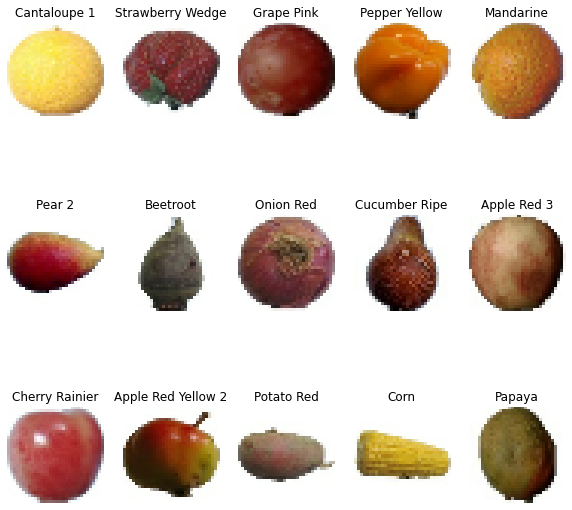

In [6]:
# List of class names
class_names = train_ds.class_names

# Visualize dataset samples
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

#### Test dataset

The "Test" directory contains 22688 images, which are going to be the test set. It is used to evaluate the resulting model after training.

In [7]:
# Get "Test" directory path
test_dir = "fruits-360/Test"

# Build train dataset
test_ds = preprocessing.image_dataset_from_directory(directory = test_dir,
                                                     batch_size = batch_size,
                                                     image_size = img_size,
                                                     color_mode = color_mode)


Found 22688 files belonging to 131 classes.


The some test samples can be visualized.

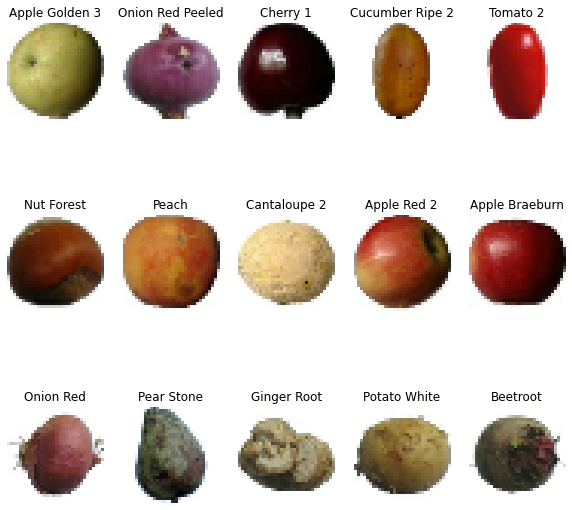

In [8]:
# Visualize dataset samples
plt.figure(figsize = (10, 10))
for images, labels in test_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## Model

The transferlearning backbone is the ResNet50 pre-trained on ImageNet, which is a dataset containing 14197122 images. It is useful to extract general, low-level features, e.g. edges, shapes, patterns, textures, gradients. Therefore, its convolutional layers weights are frozen (less likely to overfit) and the top is skipped. Then, a few layers must be appended to the top and trained to classify the images (fine-tuning). 

### Building the model

First, the input has to be preprocessed as it was during the pre-training. It is achieved with the keras.applications function `resnet50.preprocess_input()`, which converts the RGB images to BGR and zero-centers each color channel with respect to the ImageNet dataset.


In [11]:
inputs = keras.Input(shape = img_shape)
x = keras.applications.resnet50.preprocess_input(inputs)

The ResNet50 is downloaded with `Keras applications`, skipping the top layers and freezing the weights (`trainable = False`).

In [12]:
# Download ResNet50 pre-trained on ImageNet, excluding the top layers
backbone = keras.applications.ResNet50(weights = "imagenet",
                                       include_top = False,
                                       input_tensor = x)
# Freeze pre-trained weights of the model
backbone.trainable = False

The top and output layers to be trained are added to the computational graph. The top layers simple:
 - A fully connected layer with 1024 neurons, activaded by ReLU (Rectified Linear Unit);
 - A fully connected output layer with 131 neurons, activaded by Softmax. This is used to get the probability of each one of the 131 classes.

In [13]:
x = layers.Flatten()(backbone.output)
x = layers.Dense(1024, activation = "relu")(x)
x = layers.Dense(131, activation = "softmax")(x)

The computational graph is constructed and the model is compiled with:
 - `Adam optimizer`, a stochastic optimization method well suited for large parameters and data problems
 - `Sparse Categorical Cross-Entropy Loss`, useful when labels are enconded as integers. Cross-Entropy Loss (or Softmax Loss) is required to output the probability score of all classes.

In [14]:
model = tf.keras.models.Model(backbone.input, x)
model.compile(optimizer = 'adam', loss = tf.keras.losses.sparse_categorical_crossentropy, metrics = ["accuracy"])
model.summary()

[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 2, 2, 256)    0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 2, 2, 256)    590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 2, 2, 256)    0           conv4_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_0_conv (Conv2D)    (None, 2, 2, 1024)   525312      conv3_block4_out[0][0]       

### Fine-tuning

The model is trained with the training set while evaluated with the validation set. 

In [15]:
# Hyperparameters
EPOCHS = 10

history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = EPOCHS)

Epoch 1/10
1693/1693 [==============================] - 180s 103ms/step - loss: 0.3787 - accuracy: 0.9144 - val_loss: 0.0930 - val_accuracy: 0.9707
Epoch 2/10
1693/1693 [==============================] - 201s 119ms/step - loss: 0.1156 - accuracy: 0.9696 - val_loss: 0.1356 - val_accuracy: 0.9688
Epoch 3/10
1693/1693 [==============================] - 186s 109ms/step - loss: 0.0876 - accuracy: 0.9784 - val_loss: 0.0619 - val_accuracy: 0.9814
Epoch 4/10
1693/1693 [==============================] - 197s 117ms/step - loss: 0.0811 - accuracy: 0.9818 - val_loss: 0.0700 - val_accuracy: 0.9826
Epoch 5/10
1693/1693 [==============================] - 199s 118ms/step - loss: 0.0629 - accuracy: 0.9863 - val_loss: 0.1399 - val_accuracy: 0.9772
Epoch 6/10
1693/1693 [==============================] - 206s 121ms/step - loss: 0.0481 - accuracy: 0.9894 - val_loss: 0.0461 - val_accuracy: 0.9914
Epoch 7/10
1693/1693 [==============================] - 172s 102ms/step - loss: 0.0619 - accuracy: 0.9895 - val_

The Loss and Accuracy curves are plotted.

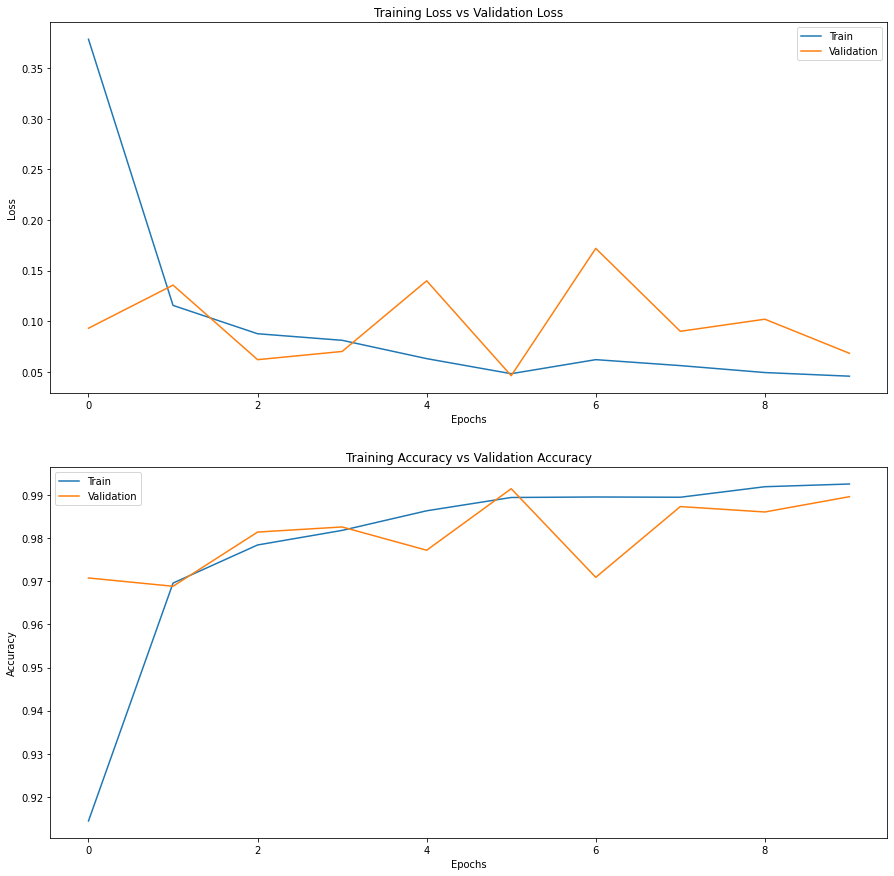

In [16]:
fig, ax = plt.subplots(2, 1, figsize = (15, 15))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Validation'])
ax[0].title.set_text('Training Loss vs Validation Loss')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train', 'Validation'])
ax[1].title.set_text('Training Accuracy vs Validation Accuracy')

plt.show()

## Tests

After the model is trained, the final tests are carried out. The evaluation determines the loss and the accuracy on the test set. The prediction presents the classification of some test samples.

### Evaluate

The test loss and accuracy are obtained with `model.evaluate()`.

In [17]:
loss, acc = model.evaluate(test_ds)

709/709 [==============================] - 64s 90ms/step - loss: 1.3492 - accuracy: 0.9017


## Predict 

It is interesting to get some image samples and check their predictions. With the function `take(1)`, it is possible to get a batch of images and run `model.predict()` on it.

In [18]:
# Get "Test" directory path
test_dir = "fruits-360/Test"

# Build train dataset
test_ds = preprocessing.image_dataset_from_directory(directory = test_dir,
                                                     batch_size = batch_size,
                                                     image_size = img_size,
                                                     color_mode = color_mode)

Found 22688 files belonging to 131 classes.


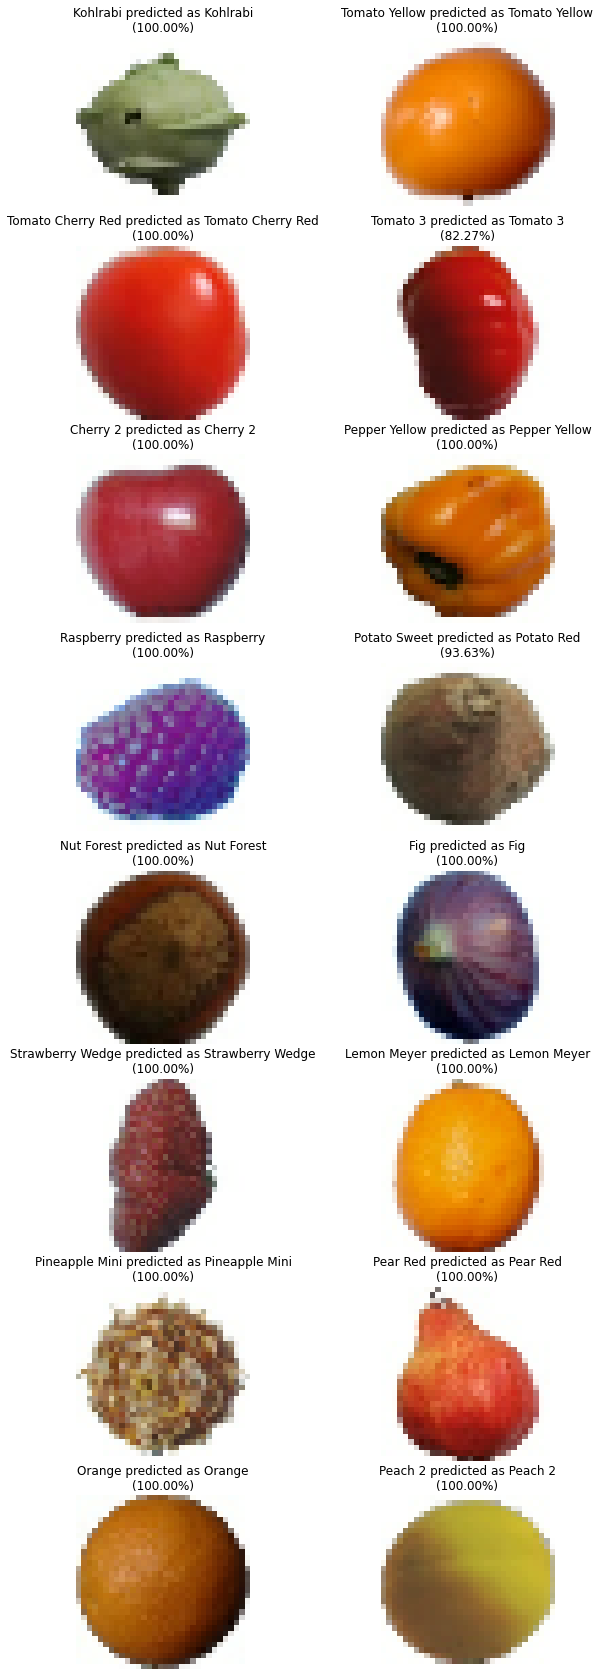

In [23]:

plt.figure(figsize = (10, 30))
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    for i in range(16):
        ax = plt.subplot(8, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_i = np.argmax(predictions[i])
        plt.title(f"{class_names[labels[i]]} predicted as {class_names[pred_i]}\n({predictions[i, pred_i]*100:.2f}%)")
        plt.axis("off")
plt.show()